<a href="https://colab.research.google.com/github/vidhirawat10/satellite-water-level-monitoring/blob/main/water_level_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive

# This will prompt you to authorize access to your Google Drive
drive.mount('/content/drive')

# Load your CSV file into a pandas DataFrame
# Make sure the file path is correct
file_path = '/content/drive/My Drive/tehri_dam_area_timeseries.csv'
df = pd.read_csv(file_path)

# Print the first 5 rows to confirm it loaded correctly
print(df.head())

Mounted at /content/drive
   system:time_start  water_area_sq_m
0       1.672551e+12     1.631298e+07
1       1.672811e+12     3.964089e+07
2       1.672983e+12     3.306946e+07
3       1.673243e+12     4.510224e+05
4       1.673415e+12     3.358368e+06


--- Cleaned Data ---
                         water_area_sq_m
date                                    
2023-01-01 05:30:34.240     1.631298e+07
2023-01-04 05:40:29.490     3.964089e+07
2023-01-06 05:30:34.421     3.306946e+07
2023-01-09 05:40:29.777     4.510224e+05
2023-01-11 05:30:31.382     3.358368e+06


<Axes: title={'center': 'Water Surface Area in Tehri Dam (2023)'}, xlabel='date'>

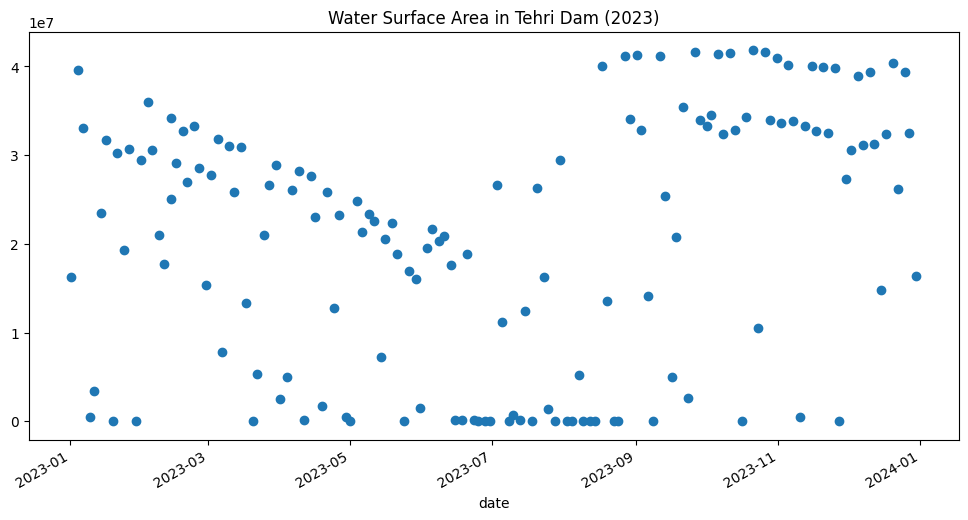

In [ ]:
# We need to install and authenticate GEE for this notebook session
import ee

# Trigger the authentication flow.
# Follow the link, copy the authorization code, and paste it.
ee.Authenticate()
ee.Initialize(project="useful-flame-383013") # Add your Google Cloud project ID here

# --- Data Cleaning and Preparation ---

# Convert the 'system:time_start' column to a proper date format
# The '.geo' column is not needed, so we drop it
df['date'] = pd.to_datetime(df['system:time_start'], unit='ms')
df = df.drop(columns=['system:time_start'])

# Set the new 'date' column as the index
df = df.set_index('date')

# Sort the data by date
df = df.sort_index()

# Display the cleaned data
print("--- Cleaned Data ---")
print(df.head())

# Let's also plot the area over time to see our clean data
df['water_area_sq_m'].plot(figsize=(12, 6), style='o',
                           title='Water Surface Area in Tehri Dam (2023)')

In [ ]:
import numpy as np

# --- Define the core function to get elevation from area ---

def get_height_for_area(target_area_sq_m):
    """
    Calculates the water elevation (height) for a given surface area using a DEM.
    """
    # Define the region of interest and the dam's lowest point (approximate)
    tehri_dam_location = ee.Geometry.Point([78.4806, 30.3804])
    analysis_area = tehri_dam_location.buffer(20000).bounds()

    # Load the SRTM Digital Elevation Model
    dem = ee.Image('USGS/SRTMGL1_003')

    # We need to find the elevation that results in the target water area.
    # This is a root-finding problem. We can solve it with an iterative search.
    # Let's define a function that calculates area for a given elevation.
    def calculate_area_at_elevation(elevation):
        # Create a water mask for all pixels at or below the given elevation
        water_mask = dem.lte(elevation)

        # Calculate the area of that mask
        area = water_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=analysis_area,
            scale=90, # Use a coarser scale for speed
            maxPixels=1e10
        )
        return ee.Number(area.get(area.keys().get(0)))

    # Iteratively search for the correct elevation
    # Start with a reasonable guess for the elevation range of the dam
    min_elev = 600  # meters
    max_elev = 900  # meters

    for _ in range(10): # 10 iterations is usually enough to converge
        mid_elev = (min_elev + max_elev) / 2
        # Get the area calculated on GEE's servers for the midpoint elevation
        area_at_mid = calculate_area_at_elevation(mid_elev).getInfo()

        if area_at_mid is None: return None # Handle cases with no water

        # Adjust our search range
        if area_at_mid < target_area_sq_m:
            min_elev = mid_elev
        else:
            max_elev = mid_elev

    # The final midpoint is our estimated elevation (height)
    final_elevation = (min_elev + max_elev) / 2
    return final_elevation

# --- Now, let's build our lookup table ---

# Get the min and max area from our dataframe to create sample points
min_area = df['water_area_sq_m'].min()
max_area = df['water_area_sq_m'].max()

# Create 10 sample points between the min and max area
sample_areas = np.linspace(min_area, max_area, 10)

print("Building Area-to-Height lookup table. This will take a few minutes...")

lookup_data = []
for area in sample_areas:
    # Calculate the corresponding height for each sample area
    height = get_height_for_area(area)
    if height:
        print(f"Area: {area:,.0f} m²  ->  Estimated Height: {height:.2f} m")
        lookup_data.append({'area': area, 'height': height})

print("\nLookup table construction complete.")

# Convert the results into a new DataFrame
lookup_df = pd.DataFrame(lookup_data)

Building Area-to-Height lookup table. This will take a few minutes...
Area: 0 m²  ->  Estimated Height: 600.15 m
Area: 4,646,689 m²  ->  Estimated Height: 600.15 m
Area: 9,293,378 m²  ->  Estimated Height: 600.15 m
Area: 13,940,068 m²  ->  Estimated Height: 618.02 m
Area: 18,586,757 m²  ->  Estimated Height: 637.94 m
Area: 23,233,446 m²  ->  Estimated Height: 654.93 m
Area: 27,880,135 m²  ->  Estimated Height: 671.04 m
Area: 32,526,824 m²  ->  Estimated Height: 683.94 m
Area: 37,173,514 m²  ->  Estimated Height: 697.12 m
Area: 41,820,203 m²  ->  Estimated Height: 707.08 m

Lookup table construction complete.


--- Final Data with Estimated Height ---
                         water_area_sq_m  estimated_height_m
date                                                        
2023-12-07 05:30:32.201     3.111140e+07          680.008932
2023-12-10 05:40:27.537     3.933130e+07          701.744710
2023-12-12 05:30:30.787     3.127861e+07          680.472810
2023-12-15 05:40:27.140     1.482759e+07          621.822676
2023-12-17 05:30:35.098     3.241386e+07          683.622170
2023-12-20 05:40:31.834     4.036011e+07          703.950132
2023-12-22 05:30:31.678     2.612893e+07          664.972293
2023-12-25 05:40:28.095     3.934105e+07          701.765600
2023-12-27 05:30:36.917     3.254257e+07          683.980210
2023-12-30 05:40:32.455     1.634577e+07          628.331630


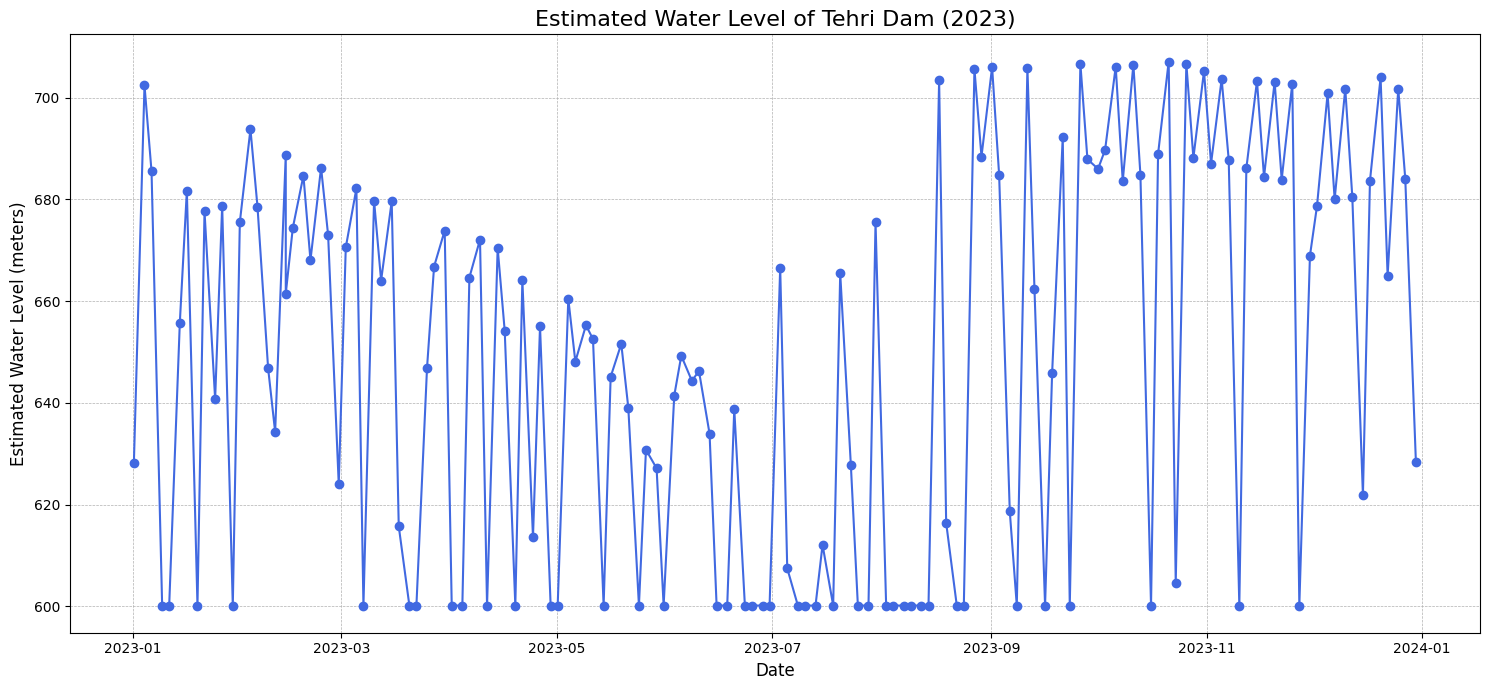

In [ ]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Extracting the area and height from our lookup table
known_areas = lookup_df['area']
known_heights = lookup_df['height']

height_interpolator = interp1d(known_areas, known_heights,
                               bounds_error=False,
                               fill_value=(known_heights.iloc[0], known_heights.iloc[-1]))

df['estimated_height_m'] = height_interpolator(df['water_area_sq_m'])


print("--- Final Data with Estimated Height ---")
print(df.tail(10))



fig, ax = plt.subplots(figsize=(15, 7))

#  water height over time - estimation
ax.plot(df.index, df['estimated_height_m'], marker='o', linestyle='-', color='royalblue')

# Plot formatting
ax.set_title('Estimated Water Level of Tehri Dam (2023)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Estimated Water Level (meters)', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()